# Dirichlet process mixture models

[Bayesian mixture models](bayesian_mixture_models.ipynb) introduced how to infer the posterior of the parameters of a mixture model with a fixed number of components $K$. We can either find $K$ using model selection, i.e. with AIC, BIC, WAIC, etc., or try to automatically infer this number. Nonparametric mixture models do exactly this. 

Here we implement a nonparametric Bayesian mixture model using *Gibbs sampling*. We use a *Chinese restaurant process* prior and stick-breaking construction to sample from a *Dirichlet process* (see for instance Nils Hjort's [*Bayesian Nonparametrics*](https://www.cambridge.org/ch/academic/subjects/statistics-probability/statistical-theory-and-methods/bayesian-nonparametrics?format=HB&isbn=9780521513463), Peter Orbanz' [lecture notes](http://stat.columbia.edu/~porbanz/papers/porbanz_BNP_draft.pdf)), Kevin Murphy's [book](https://mitpress.mit.edu/books/machine-learning-1) and last but not least Herman Kamper's [notes](https://www.kamperh.com/notes/kamper_bayesgmm13.pdf). 

We'll implement the Gibbs sampler using the CRP ourselves, since (I think) Stan doesn't allow us to do this and then use the stick-breaking construction with Stan. That is technically not possible though, so we use a small hack (a truncated DP).

**As usual I do not take warranty for the correctness or completeness of this document.**

I'll use R, cause it's the bestest!

In [1]:
options(repr.fig.width=4, repr.plot.height=3)

In [2]:
suppressMessages(library("e1071"))
suppressMessages(library("mvtnorm"))
suppressMessages(library("dplyr"))
suppressMessages(library("ggplot2"))
suppressMessages(library("MCMCpack"))
suppressMessages(library("bayesplot"))
suppressMessages(library("rlang"))
suppressMessages(library("tsne"))
set.seed(23)

In [3]:
suppressMessages(library(rstan))
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

In [Bayesian mixture models](bayesian_mixture_models.ipynb) we used following hierarchical form to describe a mixture model:

\begin{align*}
\boldsymbol \theta_k & \sim \mathcal{G}_0\\
\boldsymbol \pi &  \sim \text{Dirichlet}(\boldsymbol \alpha_0)\\
z_i &  \sim \text{Discrete}(\boldsymbol \pi)\\
\mathbf{x}_i \mid z_i = k &  \sim {P}(\boldsymbol \theta_k)
\end{align*}

where $\mathcal{G}_0$ is some base distribution for the model parameters.

The DP on contrast, as any BNP model, puts priors on structures that accomodate infinite sizes. The resulting posteriors give a distribution on structures that grow with new observations. A mixture model using an possibly infinite number of components could look like this:

\begin{align*}
\mathcal{G} & \sim \mathcal{DP}(\alpha, \mathcal{G}_0)\\
\boldsymbol \theta_i  & \sim \mathcal{G}\\
\mathbf{x}_i&  \sim {P}(\boldsymbol \theta_i)
\end{align*}

where $\mathcal{G}_0$ is the same base measure as above and $\mathcal{G}$ is a sample from the DP, i.e. also a random measure.

## The Chinese restaurant process

One way, and possibly the easiest, to implement a DPMM is using a *Chinese restaurant process* (CRP) which is a distribution over partitions.

### Data generating process

The hierarchical model using a CRP is:

\begin{align*}
\boldsymbol \theta_k & \sim \mathcal{G}_0 \\
z_i \mid \mathbf{z}_{1:i-1} & \sim \text{CRP} \\
\mathbf{x}_i & \sim P(\boldsymbol \theta_{z_i})
\end{align*}

where $\text{CRP}$ is a prior on possible infinitely many classes. Specifically the CRP is defined as:

\begin{align*}
P(z_i = k \mid \mathbf{z}_{-i}) = \left\{
                \begin{array}{ll}
                  \frac{N_k}{N - 1 + \alpha}\\
                  \frac{\alpha}{N - 1 + \alpha}\\
                \end{array}
              \right.
\end{align*}

where $N_k$ is the number of customers at table $k$ and $\alpha$ some hyperparameter.

For the variables of interest, $\boldsymbol  \theta_k$ and $\boldsymbol z$ the posterior is:

\begin{align*}
P(\boldsymbol \theta, \boldsymbol z \mid \mathbf{X}) \propto P(\mathbf{X} \mid \boldsymbol \theta, \boldsymbol z ) P(\boldsymbol \theta) P ( \boldsymbol z )
\end{align*}

Using a Gibbs sampler, we iterate over the following two steps:

1) sample $z_i \sim P(z_i \mid \mathbf{z}_{-i}, \mathbf{X}, \boldsymbol \theta) \propto P(z_i \mid \mathbf{z}_{-i}) P(\mathbf{x}_i \mid \boldsymbol \theta_{z_i}, \mathbf{X}_{-i}, \mathbf{z})$

2) sample $\boldsymbol \theta_k \sim P(\boldsymbol \theta_k \mid \mathbf{z}, \mathbf{X})$

So we alternate sampling assignments of data to classes and sampling the parameters of the data distribution given the class assignments. The major difference here compared to the finite case is the way of sampling $z_i$ which we do using the CRP in the infinite case. The CRP itself is defined by $ P(z_i \mid \mathbf{z}_{-i}) $, so replacing this by a usual finite sample would give us a finite mixture. Evaluation of the likelihoods in the first step is fairly straightforward as we will see. Updating the model parameters in the second step is conditional on every class, an by that also not too hard to do.

## Stick-breaking construction

With the CRP with put a prior distribution on the possibly infinite number of class assignments. An alternative approach is to use *stick-breaking* construction. The advantage here is that we could use `Stan` using a truncated DP, thus we don't need to implement the sampler ourselves.

### Data generating process

If we, instead of putting a CRP prior on the latent labels, put a prior on the possibly infinite sequence of mixing weights $\boldsymbol \pi$ we arrive at the *stick-breaking* construction. The hierarchical model now looks like this:

\begin{align*}
\nu_k &\sim \text{Beta}(1, \alpha) \\
\pi_k & = \nu_k  \prod_{j=1}^{k-1} (1 - \nu_j) \\
\boldsymbol \theta_k & \sim G_0 \\
\mathbf{x}_i & \sim \sum_k \pi_k P(\boldsymbol \theta_k)
\end{align*}

where $N_k$ is the number of customers at table $k$ and $\alpha$ some hyperparameter. The distribution of the mixing weights is sometimes denoted as

$$
\boldsymbol \pi \sim \text{GEM}(\alpha)
$$

## Gaussian DPMM

In the following section, we derive a Gaussian Dirichlet process mixture using the CRP with a Gibbs sampler and the stick-breaking construction using Stan.

### CRP

In the Gaussian case the hierarchical model using the CRP has the following form:

\begin{align*}
\boldsymbol \Sigma_k & \sim \mathcal{IW}\\
\boldsymbol \mu_k & \sim \mathcal{N}(\boldsymbol \mu_0, \boldsymbol \Sigma_0) \\
z_i \mid z_{1:i-1} & \sim \text{CRP} \\
\mathbf{x}_i & \sim \mathcal{N}(\boldsymbol \mu_{z_i}, \boldsymbol \Sigma_{z_i})
\end{align*}

Let's derive the Gibbs sampler for a infinite Gaussian mixture using the CRP.

First we set data $\mathbf{X}$ some constants. We create a very simple data set to avoid problems with identifiability and label switching. For a treatment of the topic see Michael Betancourt's [case study](https://betanalpha.github.io/assets/case_studies/identifying_mixture_models.html). $n$ is the number of samples, $p$ is the dimensionality of the Gaussian, $\alpha$ is the Dirichlet concentration.

In [4]:
n <- 100
p <- 2
alpha <- .5

Latent class assignments (`Z`), the current table index and the number of customers per table:

In [5]:
Z <- integer(n)
X <- matrix(0, n, p)
curr.tab <- 0
tables <- c()

Parameters of the Gaussians:

In [6]:
sigma <- .1
mus <- NULL

Then we create a random assignment of customers to tables with probability $P(z_i \mid Z_{-i})$, i.e. we use the CRP to put data into classes.
Note that we don't know the number of classes that comes out!

In [7]:
for (i in seq(n))
{   
    probs <- c(tables / (i - 1 + alpha), alpha / (i - 1 + alpha))
    table <- rdiscrete(1, probs)
    if (table > curr.tab) 
    {
        curr.tab <- curr.tab + 1
        tables <- c(tables, 0)
        mu <- mvtnorm::rmvnorm(1, c(0, 0), 10 * diag(p))
        mus <- rbind(mus, mu)
    }
    Z[i] <- table
    X[i,] <- mvtnorm::rmvnorm(1, mus[Z[i], ], sigma * diag(p))
    tables[table] <-  tables[table] + 1
}

Let's see how many clusters and how many data points per clusters we have.

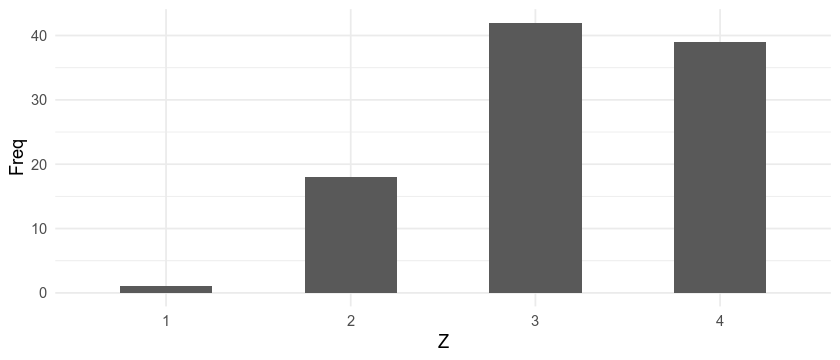

In [8]:
data.frame(table(Z))%>%
    ggplot() +
    geom_col(aes(Z, Freq), width=.5) +
    theme_minimal()

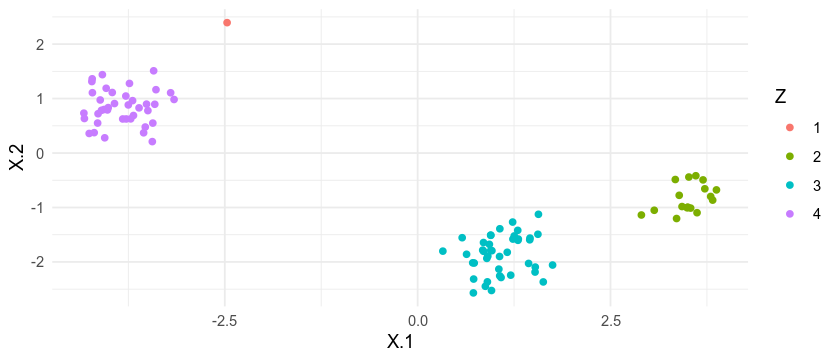

In [9]:
data.frame(X=X, Z=as.factor(Z)) %>%
    ggplot() +
    geom_point(aes(X.1, X.2, col=Z)) +
    theme_minimal()

#### Posterior inference using Gibbs sampling

Let's infer the posteriors.

We randomly initialize the cluster assignments and set all customers to table 1. Hyperparameter $\alpha$ controls the probability of opening a new table.

In [10]:
# initialization of the cluster assignments
K <- 1
zs <- rep(K, n)
alpha <- 5
tables <- n

Define the priors of the model. We set the covariances to be fixed.

In [11]:
mu.prior <- matrix(c(0, 0), ncol = 2)
sigma.prior <- diag(p)
q.prior <- solve(sigma.prior)

Base distribution $\mathcal{G}_0$:

In [12]:
sigma0 <- diag(p)
prec0 <- solve(sigma0)
mu0 <- rep(0, p)

To infer the posterior we would use the Gibbs sampler described above. Here, I am only interested in the most likely assignment, i.e. the map of $Z$.

In [13]:
for (iter in seq(100))
{
  for (i in seq(n))
  {
    # look at data x_i and romove its statistics from the clustering
    zi <- zs[i]
    tables[zi] <- tables[zi] - 1
    if (tables[zi] == 0) {
      K <- K - 1
      zs[zs > zi] <- zs[zs > zi] - 1
      tables <- tables[-zi]
      mu.prior <- mu.prior[-zi, ]
    }
    
    # compute posterior probabilitites P(z_i \mid z_-i, ...)
    no_i <- seq(n)[-i]
    probs <- sapply(seq(K), function(k) {
      crp <- sum(zs[no_i] == k) / (n + alpha - 1)
      lik <- mvtnorm::dmvnorm(X[i, ], mu.prior[k,], sigma.prior)
      crp * lik
    })
    
    # compute probability for opening up a new one
    crp <- alpha / (n + alpha - 1)
    lik <- mvtnorm::dmvnorm(X[i, ], mu0, sigma.prior + sigma0)
    probs <- c(probs, crp * lik)
    probs <- probs / sum(probs)
    
    # sample new z_i according to the conditional posterior above
    z_new <- which.max(probs)
    if (z_new > K) {
      K <- K + 1
      tables <- c(tables, 0)
      mu.prior <- rbind(mu.prior, mvtnorm::rmvnorm(1, mu0, sigma0))
    }
    zs[i] <- z_new        
    tables[z_new] <- tables[z_new] + 1
    
    # compute conditional posterior P(mu \mid ...)
    for(k in seq(K)) {
      Xk <- X[zs == k, ,drop=FALSE]
      lambda <- solve(q.prior + tables[k] * q.prior)
      nominator <- tables[k] * q.prior %*% apply(Xk, 2, mean)
      mu.prior[k, ] <- mvtnorm::rmvnorm(1, lambda %*% nominator, lambda)
    }
  }
}

Let's see if that worked out!

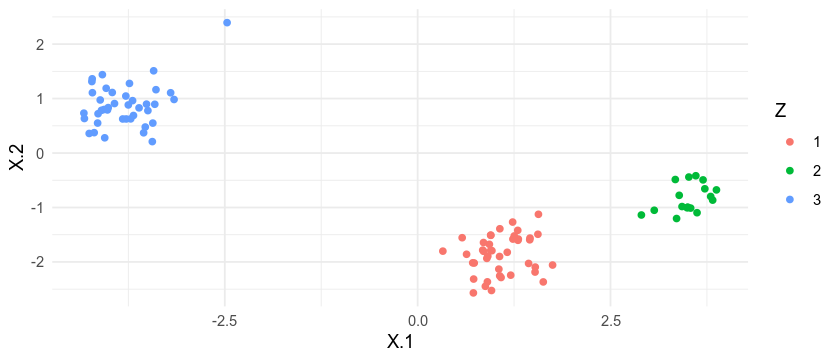

In [14]:
data.frame(X=X, Z=as.factor(zs)) %>%
    ggplot() +
    geom_point(aes(X.1, X.2, col=Z)) +
    theme_minimal()

Cool, except for the lone guy on top the clustering worked nicely.

### Stick breaking construction

In order to make the DPMM with stick-breaking work in Stan, we need to supply a maximum number of clusters $K$ from which we can choose. Setting $K=n$ would mean that we allow that every data point defines its own cluster. For the sake of the exercise I'll set it the maximum number of clusters to $10$. The hyperparameter $\alpha$ parameterizes the Beta-distribution which we use to sample stick lengths. We use the same data we already generated above.

In [15]:
K <- 10
alpha <- 2

The model is a bit more verbose in comparison to the finite case ([Bayesian mixture models](bayesian_mixture_models.ipynb)). We only need to add the stick breaking part in the `transformed parameters`, the rest stays the same. We again use the LKJ prior for the correlation matrix of the single components and set a fixed prior scale of $1$. In order to get nice, unimodel posteriors, we also introduce an ordering of the mean values.

In [17]:
stan.file <- "_models/dirichlet_process_mixture.stan"
cat(readLines(stan.file), sep="\n")

data {
	int<lower=0> K;
	int<lower=0> n;
	int<lower=1> p;
	row_vector[p] x[n];
	real alpha;
}

parameters {    	
  	ordered[p] mu[K];
	cholesky_factor_corr[p] L;
	real <lower=0, upper=1> nu[K];
}

transformed parameters {
  simplex[K] pi;
  pi[1] = nu[1];
  for(j in 2:(K-1)) 
  {
      pi[j] = nu[j] * (1 - nu[j - 1]) * pi[j - 1] / nu[j - 1]; 
  }

  pi[K] = 1 - sum(pi[1:(K - 1)]);
}

model {
  	real mix[K];

  	L ~ lkj_corr_cholesky(5);
  	nu ~ beta(1, alpha);	
	for (i in 1:K) 
	{
		mu[i] ~ normal(0, 5);
	}

  
  	for(i in 1:n) 
  	{
		for(k in 1:K) 
		{
			mix[k] = log(pi[k]) + multi_normal_cholesky_lpdf(x[i] | mu[k], L);
		}
		target += log_sum_exp(mix);
  	}
}


In [18]:
fit <- stan(stan.file, data = list(K=K, n=n, x=X, p=p, alpha=alpha), iter = 10000, warmup = 1000, chains = 1)


SAMPLING FOR MODEL 'dirichlet_process_mixture' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000827 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 8.27 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 1001 / 10000 [ 10%]  (Sampling)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Sampling)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Sampling)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Sampling)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 82.0988 seconds (Warm-up)
Chain 1:                363.926 second

In [19]:
fit

Inference for Stan model: dirichlet_process_mixture.
1 chains, each with iter=10000; warmup=1000; thin=1; 
post-warmup draws per chain=9000, total post-warmup draws=9000.

            mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff
mu[1,1]    -3.83    0.00 0.16   -4.15   -3.95   -3.83   -3.73   -3.52  4797
mu[1,2]     0.84    0.00 0.16    0.52    0.73    0.84    0.95    1.14  4927
mu[2,1]    -0.40    0.00 0.04   -0.48   -0.43   -0.40   -0.37   -0.32  6577
mu[2,2]    -0.37    0.00 0.04   -0.45   -0.40   -0.37   -0.34   -0.29  8537
mu[3,1]     1.31    0.00 0.06    1.19    1.27    1.31    1.35    1.44  5940
mu[3,2]     1.36    0.00 0.06    1.24    1.31    1.36    1.40    1.49  7754
mu[4,1]    -2.82    0.05 3.81  -10.69   -5.11   -2.85   -0.34    4.81  6463
mu[4,2]     2.53    0.04 3.91   -4.87    0.04    2.18    5.01   10.76  8667
mu[5,1]    -2.79    0.05 3.89  -10.78   -5.25   -2.76   -0.20    4.61  6474
mu[5,2]     2.73    0.04 3.94   -4.78    0.16    2.45    5.25   10.9

No divergent transitions and $\hat{R}$s of one looks good. Our model seems well specified! Let's look at some plots though. First the traces for the means and mixing weights.

In [20]:
posterior_pi <- as.array(fit, pars = c("pi"))
posterior_mu <- as.array(fit, pars = c("mu"))
np <- nuts_params(fit)

No divergences to plot.


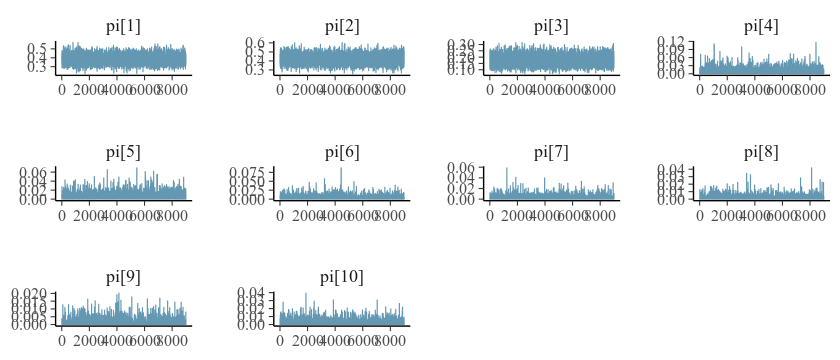

In [21]:
mcmc_trace(posterior_pi, np = np)

No divergences to plot.


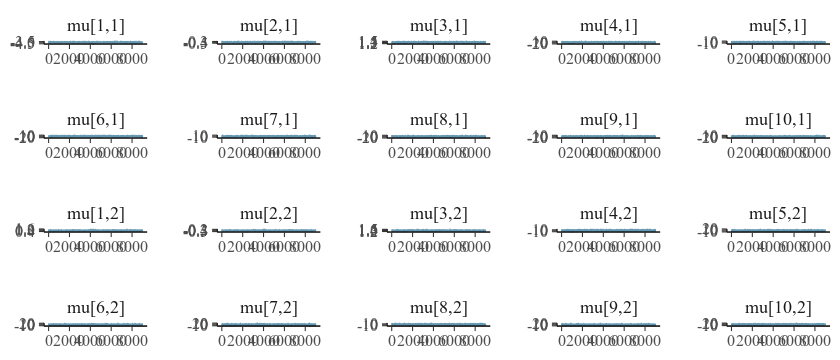

In [22]:
mcmc_trace(posterior_mu, np = np)

Both plots look excellent. Let's plot the posteriors distributions of the mixing weights, too, from which we can decide how many components we need.

In [23]:
posterior <- extract(fit)

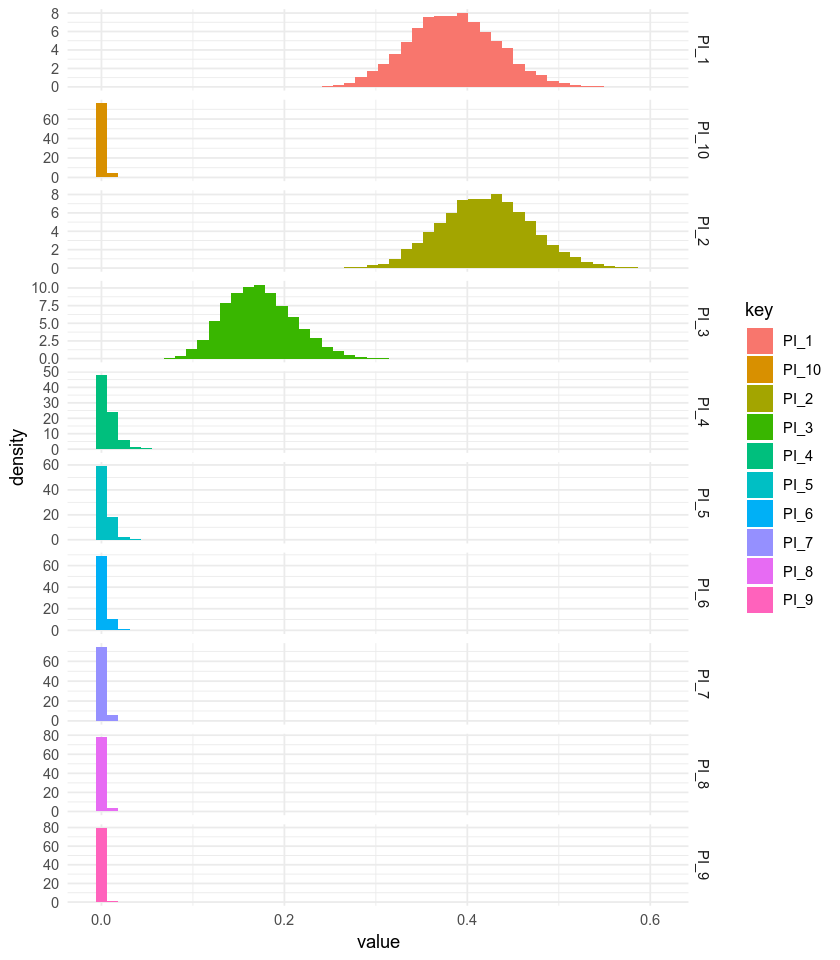

In [24]:
options(repr.fig.width=4, repr.plot.height=8)
data.frame(posterior$pi)  %>% 
    set_names(paste0("PI_", 1:10)) %>%
    tidyr::gather(key, value) %>%
    ggplot(aes(x = value, y = ..density.., fill=key), position="dodge") + 
    facet_grid(key ~ ., scales="free") +
    geom_histogram(bins=50) +
    theme_minimal()

From the plot above it looks as if Stan believes it's sufficient to use three components as the means of the mixing weights of the seven other components are fairly low or even zero. However, let's extract all means of the posterior means and assign each data point to a cluster.

In [25]:
post.mus <- do.call(
    "rbind", 
    lapply(1:10, function(i) apply(posterior$mu[,i,], 2, mean)))

In [26]:
probs <- purrr::map_dfc(seq(10), function(i) {
    mvtnorm::dmvnorm(X, post.mus[i,], diag(2))}) %>% 
    set_names(paste0("Z", seq(10)))

In [27]:
zs.stan <- apply(probs, 1, which.max)

And the final plot:

In [28]:
options(repr.fig.width=4, repr.plot.height=3)

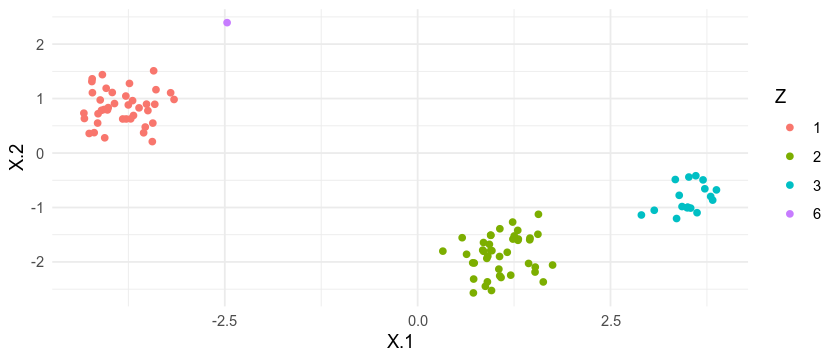

In [29]:
data.frame(X=X, Z=as.factor(zs.stan)) %>%
    ggplot() +
    geom_point(aes(X.1, X.2, col=Z)) +
    theme_minimal()

Cool, our small hack using Stan and stick-breaking worked even better than our CRP implementation. Here, we managed to give every point its correct label.

## Multivariate Bernoullis

Next, we derive a Dirichlet process mixture for a multivariate Bernoulli distribution (or whatever name is more suitable here). We again use the CRP with a Gibbs sampler and the stick-breaking construction using Stan.

### CRP

We model every observation $\mathbf{x} \in \{0, 1 \}^p$ as:

\begin{align*}
\pi_{{z_i}_j} & \sim \text{Beta}(a, b)\\
z_i \mid z_{1:i-1} & \sim \text{CRP} \\
x_{i, j} \mid z_i & \sim \text{Bernoulli}(\pi_{{z_i}_j}),
\end{align*}

with hyperparameters $a$ and $b$. Thus the likelihood for one datum is the product over $p$ independent Bernoullis:

$$P(\mathbf{x} \mid z, \boldsymbol \Pi) = \prod_{j=1}^p \pi_{{z_i}_j}^{x_j} \cdot (1 - \pi_{{z_i}_j})^{(1 - x_j)}$$

First we again generate some data. We sample $100$ points $\mathbf{X}$ from a $p=5$ dimensional mixture of a $k=3$ multivariate Bernoullis and their latent class assignments $\mathbf{z}$ (since we already saw how one can generate data using a CRP).

In [30]:
n <- 200
p <- 3
alpha <- 0.5
k <- 3
Z <- sample(1:k, n, replace = T)
table(Z)

Z
 1  2  3 
66 65 69 

Then we generate the true success probabilities for every Bernoulli. These are $k \cdot p$ many. We simulate an easy scenario where every dimension has the same probability for every class.

In [31]:
probs.true <- matrix(seq(0.1, 0.9, length.out=k), k, p)
probs.true

0.1,0.1,0.1
0.5,0.5,0.5
0.9,0.9,0.9


Then we generate the data using these probabilities randomly:

In [32]:
probs.matrix <- probs.true[Z, ]
X  <- (probs.matrix > matrix(runif(n * p), n, p)) * 1L
head(X)

1,1,1
1,1,0
1,1,1
0,1,1
0,1,0
0,0,0


Let's have a look at it using $t$-SNE. Note, that since the data are Bernoulli, axes are kinda hard to interpret and we shouldn't get a clear separation of the clusters as in the Gaussian case (the same is true for PCA, too).

In [33]:
tsne.data <- tsne(X, perplexity = 50, max_iter = 1500)

sigma summary: Min. : 2.98023223876953e-08 |1st Qu. : 2.98023223876953e-08 |Median : 2.98023223876953e-08 |Mean : 0.324849420029501 |3rd Qu. : 0.877051842675364 |Max. : 0.880859644720498 |
Epoch: Iteration #100 error is: 10.1077225877546
Epoch: Iteration #200 error is: 0.117129242433764
Epoch: Iteration #300 error is: 0.108879834557257
Epoch: Iteration #400 error is: 0.108639249916817
Epoch: Iteration #500 error is: 0.108639116941492
Epoch: Iteration #600 error is: 0.108639115185507
Epoch: Iteration #700 error is: 0.108639114196984
Epoch: Iteration #800 error is: 0.108639113574556
Epoch: Iteration #900 error is: 0.108639113159462
Epoch: Iteration #1000 error is: 0.108639112876913
Epoch: Iteration #1100 error is: 0.108639112677704
Epoch: Iteration #1200 error is: 0.108639112530351
Epoch: Iteration #1300 error is: 0.10863911242723
Epoch: Iteration #1400 error is: 0.108639112331463
Epoch: Iteration #1500 error is: 0.108639112247686


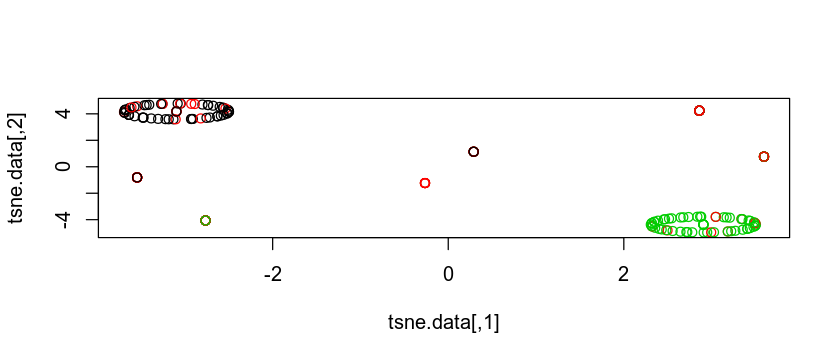

In [34]:
plot(tsne.data, col=Z)

We use a concentration of $\alpha=1$ for the CRP and $a=b=1$ as hyperparameters for the Beta to get a somewhat uniform shape.

In [35]:
alpha <- 1
a <- b <- 1

As for the Gaussian case, we need to compute the likelihood of $\mathbf{x}_i$ evaluated at its cluster $k$. Since we factorize over $p$ independent Bernoullis, we need to write down this likelihood manually:

In [36]:
# likelihood for existing cluster
ppd <- function(x, ps)
{

  exp(sum(x * log(ps) + (1 - x) * (1 - log(ps))))
}

# likelihood for random new cluster
ppde <- function(x)
{
  ps <- rbeta(p, a, b)
  ppd(x, ps)
}

For the sample we start with the following initial parameter settings: one cluster $K=1$, i.e. all latent class assignments are $\mathbf{z} = \{1 \}^n$, and $p$ random samples from a Beta for the success probabilities of the Bernoullis determining the cluster.

In [37]:
K <- 1
zs <- rep(K, n)
tables <- n
priors <- array(rbeta(p, a, b), dim = c(1, p, 1))
priors

, , 1

          [,1]      [,2]      [,3]
[1,] 0.2752231 0.5964588 0.9296132

Then we implement the Gibbs sampler (or rather the ECM):

In [38]:
for (it in seq(100))
{
  for (i in seq(n))
  {
    # look at data x_i and romove its statistics from the clustering
    zi <- zs[i]
    tables[zi] <- tables[zi] - 1
    if (tables[zi] == 0) {
      K <- K - 1
      zs[zs > zi] <- zs[zs > zi] - 1
      tables <- tables[-zi]
      priors <- priors[,,-zi,drop=FALSE]
    }

    # compute posterior probabilitites P(z_i \mid z_-i, ...)
    no_i <- seq(n)[-i]
    probs <- sapply(seq(K), function(k) {
      crp <- sum(zs[no_i] == k) / (n + alpha - 1)
      lik <- ppd(X[i, ], priors[,,k])
      crp * lik
    })

    # compute probability for opening up a new one
    crp <- alpha / (n + alpha - 1)
    lik <- ppde(X[i, ])
    probs <- c(probs, crp * lik)
    probs <- probs / sum(probs)

    # sample new z_i according to the conditional posterior above
    z_new <- which.max(probs)
    if (z_new > K) {
      K <- K + 1
      tables <- c(tables, 0)
      priors <- abind::abind(priors, array(rbeta(p, a, b), dim=c(1, p, 1)))
    }
    zs[i] <- z_new
    tables[z_new] <- tables[z_new] + 1
    # compute conditional posterior P(mu \mid ...)
    for(k in seq(K))
    {
      Xk <- X[zs == k, ,drop=FALSE]
      priors[,,k] <- sapply(colSums(Xk), function(i) rbeta(1, i + 1, nrow(Xk) - i + 1))
    }
  }
}

Let's compare the inferred assignments with the true ones.

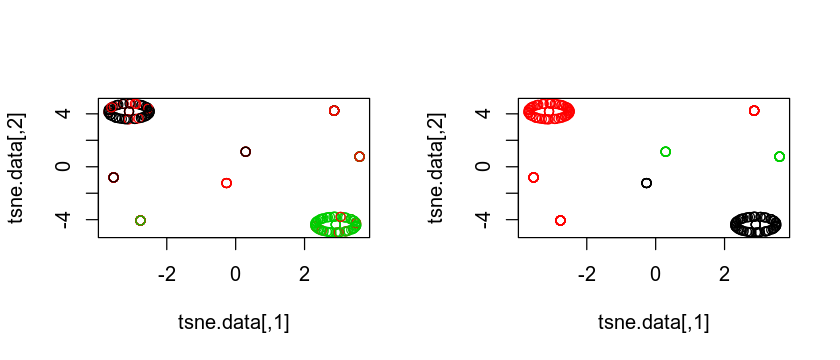

In [39]:
par(mfrow=c(1, 2))
plot(tsne.data, col=Z)
plot(tsne.data, col=zs)

### Stick-breaking construction

As above, we try to implement the mixture using Stan, too. We use a truncated DP again and set the maximum number of clusters $K =5$, because the model is quite hard to compute and we don't use a lot of data, and the concentration to $\alpha=2$.

In [40]:
K <- 5
alpha <- 2

The respective Stan file is similar to the Gaussian case. There is one more tricky part, though. In the Gaussian case, we needed to order the mean vectors such that we can identifiable posteriors. For the binary case, we in addition need to make sure that the parameters are probabilities, i.e. have a domain from $0$ to $1$. We do that by first declaring a $K \times p$-dimensional parameter `rates` which we order: `ordered[p] rates[K]`. Then, in order to make a probability out of it, we apply the inverse logit function for every element: `prob = inv_logit(rates)`. That should do the trick. The complete Stan file is shown below.

In [41]:
stan.file <- "_models/binary_dirichlet_process_mixture.stan"
cat(readLines(stan.file), sep="\n")

data {
	int<lower=1> K;
	int<lower=1> n;
	int<lower=1> p;
	real<lower=0> a;
	real<lower=0> b;
	int<lower=0,upper=1> x[n, p];
	real<lower=1> alpha;
}

parameters {    	
  	ordered[p] rates[K];
	real<lower=0, upper=1> nu[K];	
}

transformed parameters {
  simplex[K] pi;
  vector<lower=0, upper=1>[p] prob[K];

  pi[1] = nu[1];
  for(j in 2:(K-1)) 
  {
      pi[j] = nu[j] * (1 - nu[j - 1]) * pi[j - 1] / nu[j - 1]; 
  }

  pi[K] = 1 - sum(pi[1:(K - 1)]);
  for (k in 1:K) 
  {
  	for (ps in 1:p) 
  	{
  		prob[k, ps] = inv_logit(rates[k, ps]);  
  	}
  }   
}

model {
  	real mix[K];
  	nu ~ beta(1, alpha);	
  
  	for(i in 1:n) 
  	{
		for(k in 1:K) 
		{
			mix[k] = log(pi[k]);
			for (ps in 1:p)
			{
				mix[k] += bernoulli_lpmf(x[i, ps] | prob[k, ps]);
			}
		}
		target += log_sum_exp(mix);
  	}
}


In [42]:
fit <- stan(stan.file, data = list(K=K, n=n, x= matrix(as.integer(X), n, p), p=p, alpha=alpha, a=1, b=1),
            iter = 20000, warmup = 10000, chains = 1, control = list(adapt_delta = 0.99))


SAMPLING FOR MODEL 'binary_dirichlet_process_mixture' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000728 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 7.28 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:     1 / 20000 [  0%]  (Warmup)
Chain 1: Iteration:  2000 / 20000 [ 10%]  (Warmup)
Chain 1: Iteration:  4000 / 20000 [ 20%]  (Warmup)
Chain 1: Iteration:  6000 / 20000 [ 30%]  (Warmup)
Chain 1: Iteration:  8000 / 20000 [ 40%]  (Warmup)
Chain 1: Iteration: 10000 / 20000 [ 50%]  (Warmup)
Chain 1: Iteration: 10001 / 20000 [ 50%]  (Sampling)
Chain 1: Iteration: 12000 / 20000 [ 60%]  (Sampling)
Chain 1: Iteration: 14000 / 20000 [ 70%]  (Sampling)
Chain 1: Iteration: 16000 / 20000 [ 80%]  (Sampling)
Chain 1: Iteration: 18000 / 20000 [ 90%]  (Sampling)
Chain 1: Iteration: 20000 / 20000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1187.29 seconds (Warm-up)
Chain 1:                819.

Warning message:
“There were 9888 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“There were 100 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

That is unpleasant! A lot of divergent transitions and almost all of the transitions exceeded the maximum tree depth (see the [Stan manual](https://mc-stan.org/docs/2_18/reference-manual/hmc-algorithm-parameters.html)). The divergent transitions are more severe a problem than the transitions so let's look at some diagnostic plots.

In [43]:
posterior_cp_pi <- as.array(fit, pars = c("pi"))
posterior_cp_prob <- as.array(fit, pars = c("prob"))
np_cp <- nuts_params(fit)

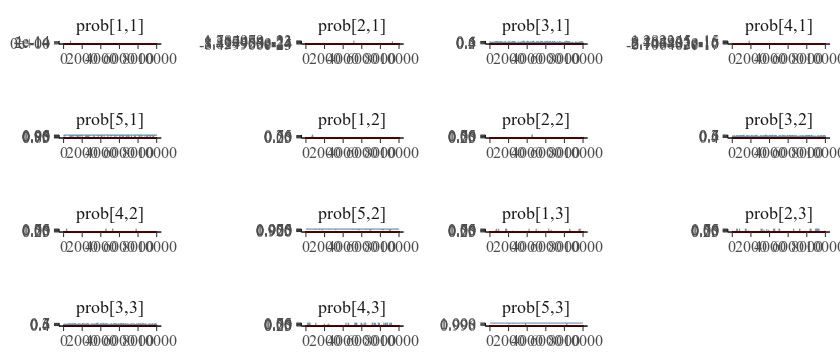

In [44]:
mcmc_trace(posterior_cp_prob,np = np_cp)

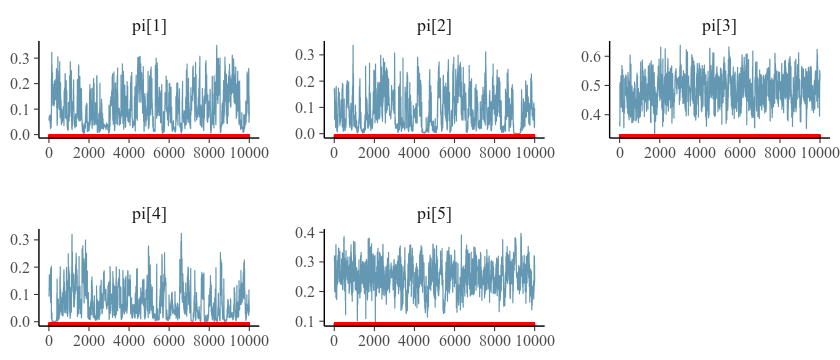

In [45]:
mcmc_trace(posterior_cp_pi,np = np_cp)

Overall the transitions divergence at allmost all points, the traces are not consequently not nice either, but it does not look too problematic. Let's also look at the effective sample size.

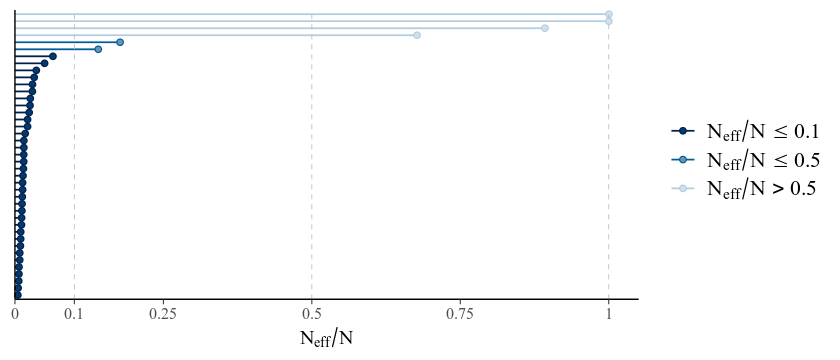

In [46]:
ratios_cp <- neff_ratio(fit)
mcmc_neff(ratios_cp)

Yuk! Most of the effective sample sizes are extremely low. Before we go on, we should try to change our model, since often badly setup models cause unpleasant posterior analytics